# Pipeline for High-z Radio Galaxies 18: Redshift prediction

## Introduction

Training for regression (prediction) of redshift for sources in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue. But regression  
will be done with AGN from the Million Quasar Catalog (MQC) and QSO from SDSS DR16.  
Only sources with confirmed $z$ will be used.

Being either AGN or galaxy will not be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import mpl_scatter_density
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef
# from sklearn.calibration import calibration_curve
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
import cmasher as cmr
# from pycaret import classification as pyc
from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd

In [2]:
mpl.rcdefaults()

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [3]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [4]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
cmap_alt_2     = cm.get_cmap('Greys_r')  # Shades of grey
cmap_alt_3     = cm.get_cmap('coolwarm')  # blue to red
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_3       = [cmap(0.25), cmap(0.50), cmap(0.75)]
colors_3_alt   = [cmap_alt(0.25), cmap_alt(0.50), cmap_alt(0.75)]
colors_3_alt_2 = [cmap_alt_2(0.25), cmap_alt_2(0.50), cmap_alt_2(0.75)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_8_alt_2 = [cmap_alt_2(0.06), cmap_alt_2(0.18), cmap_alt_2(0.29), cmap_alt_2(0.42), cmap_alt_2(0.54),\
                  cmap_alt_2(0.66), cmap_alt_2(0.78), cmap_alt_2(0.90)]
colors_8_alt_3 = [cmap_alt_3(0.06), cmap_alt_3(0.18), cmap_alt_3(0.29), cmap_alt_3(0.42), cmap_alt_3(0.54),\
                  cmap_alt_3(0.66), cmap_alt_3(0.78), cmap_alt_3(0.90)]

In [5]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Define specific metrics for redshift values:  

$$
\sigma_{\mathrm{NMAD}} = 1.48 \times \mathrm{median}\left(\frac{|(z_{True} - z_{Predict})|}{(1 + z_{True})}\right)
$$

In [6]:
def sigma_mad(z_true, z_pred, **kwargs):
    med = np.nanmedian(np.abs(z_true - z_pred)).astype('float32')
    return 1.48 * med

In [7]:
def sigma_nmad(z_true, z_pred, **kwargs):
    dif  = (z_true - z_pred)
    frac = dif / (1 + z_true).values
    med  = np.nanmedian(np.abs(frac)).astype('float32')
    return 1.48 * med

In [8]:
def sigma_z(z_true, z_pred, **kwargs):
    dif = z_true - z_pred
    ssq = np.sum(dif**2)
    rot = np.sqrt(ssq / len(z_true)).astype('float32')
    return rot

In [9]:
def sigma_z_norm(z_true, z_pred, **kwargs):
    dif = (z_true - z_pred) / (1 + z_true)
    ssq = np.sum(dif**2)
    rot = np.sqrt(ssq / len(z_true)).astype('float32')
    return rot

In [10]:
def outlier_frac(z_true, z_pred, **kwargs):
    dif  = np.abs((z_true - z_pred) / (1 + z_true))
    siz  = np.sum(np.isfinite(dif)).astype('float32')
    num  = np.sum(np.array(dif > 0.15)).astype('float32')
    frac = num / siz
    return frac

Methdods for PyCaret and saved models.

In [11]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        for (name, method) in pyr.get_config('prep_pipe').named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [12]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

In [13]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                              display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize()

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(30)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title)
    plt.tight_layout()

In [14]:
def get_base_estimators_names(pycaret_pipeline):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        estimators  = pycaret_pipeline['trained_model'].estimators
    else:
        estimators  = pycaret_pipeline.estimators

    estimators_list = [estimator[0] for estimator in estimators]
    return estimators_list

Methods to create values of metrics by redshift ranges

In [15]:
def z_metric_in_z_ranges(data_set_df, z_col, z_range, metric_function, *metricArgs):
    metric_output  = np.zeros_like(z_range)
    true_vals      = metricArgs[0]
    predicted_vals = metricArgs[1]
    for count, z_thresh in enumerate(z_range):
        filter_z             = data_set_df.loc[:, z_col] >= z_thresh
        if np.sum(filter_z) == 0:
            metric_output[count] = np.nan
            continue
        sub_set              = data_set_df.loc[filter_z, [*metricArgs]]
        metric_output[count] = metric_function(sub_set.loc[:, true_vals], sub_set.loc[:, predicted_vals])
    return metric_output

Method to plot metrics

In [16]:
def plot_metric_over_z(z_range, metric_range, name_metric, ax_pre, title=None, color=plt.get_cmap('cmr.redshift')(0.8)):
    ax_pre.plot(z_range, metric_range, color=color, zorder=10, alpha=0.93, marker='o', ls='-', lw=2.5)
    ##
    ax_pre.set_xlabel('$z_{\mathrm{True}}$', fontsize=20)
    ax_pre.set_ylabel(f'$\mathrm{{{name_metric}}} (\geq z)$', fontsize=20)
    ax_pre.tick_params(which='both', top=True, right=True, direction='in')
    ax_pre.tick_params(axis='both', which='major', labelsize=16)
    ax_pre.tick_params(which='major', length=8, width=1.5)
    ax_pre.tick_params(which='minor', length=4, width=1.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    ax_pre.set_title(title, fontsize=14)
    ax_pre.grid(visible=True, alpha=0.1, zorder=0)
    plt.tight_layout()

***

## Reading data

In [17]:
cat_path = '../../Catalogs/'  # relative path to the same directory

We import our data using the `pandas` package.

In [18]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = True

In [19]:
use_5sigma = True  # use files with 5-sigma magnitude imputation

In [20]:
mqc_version = '7_4d'  # '7_2'

In [21]:
file_name_train = f'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_{mqc_version}_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'  # 6729647 objects (6.7e6)

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [22]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'X_ray_detect', 'Total_flux_VLASS', 'Sint_LOFAR', 'Stotal_TGSS',\
                     'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [23]:
full_catalog_df = pd.read_hdf(cat_path + file_name_train, key='df').drop(columns=features_2_discard)

In [24]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

In [25]:
# full_catalog_df.describe()

#### Select only confirmed radio AGN

In [26]:
n_full   = len(full_catalog_df)
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, 'radio_detect'] == 1)
print(f'In this dataset, with {n_full:,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, {n_is_gal:,} have been indentified as galaxies,' +\
      f' and {n_is_rad:,} are identified as radio detections.')

In this dataset, with 6,729,647 elements,
28,251 of them are marked as AGN, 55,158 have been indentified as galaxies, and 345,498 are identified as radio detections.


---

Combine redshift values (AGN + galaxies).

In [27]:
idx_non_Z                = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

---

## Possible correlations

In [28]:
print(full_catalog_df.columns.to_list())

['Z', 'zsp', 'spCl', 'band_num', 'radio_detect', 'is_str', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag', 'g_r', 'g_i', 'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1', 'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3', 'W2_W4', 'W3_W4']


---

## Random seed

In [29]:
seed = 42

Create target

In [30]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

## Split data: Test, Train, Validation

Create same train/test/validation sub-sets as with AGN/galaxy model.  
After this, select sources needed for this model (`is_AGN == 1` and `radio_detect == 1`).

In [31]:
filter_known_spec  = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
filter_known_radio = full_catalog_df.loc[:, 'radio_detect'] == 1
full_catalog_df    = full_catalog_df.loc[filter_known_spec]
train_test_df, validation_df     = train_test_split(full_catalog_df, test_size=0.2,\
                                    random_state=seed, stratify=full_catalog_df.loc[:, 'is_AGN'])
train_df, test_df                = train_test_split(train_test_df, test_size=0.3,\
                                    random_state=seed, stratify=train_test_df.loc[:, 'is_AGN'])
print('Shape of used data in HETDEX')
print('(Confirmed galaxies and AGN)')
print('-' * 50)
print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Training data:                      {train_df.shape}')
print(f'Testing data:                       {test_df.shape}')
print(f'Validation data:                    {validation_df.shape}')
print('-' * 50)
print()

Shape of used data in HETDEX
(Confirmed galaxies and AGN)
--------------------------------------------------
Full confirmed dataset size:        (83409, 87)
Data for Modeling (Train and Test): (66727, 87)
Training data:                      (46708, 87)
Testing data:                       (20019, 87)
Validation data:                    (16682, 87)
--------------------------------------------------



In [32]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_AGN'] == 1) & (full_catalog_df.loc[:, 'radio_detect'] == 1)]
train_test_df   = train_test_df.loc[(train_test_df.loc[:, 'is_AGN'] == 1) & (train_test_df.loc[:, 'radio_detect'] == 1)]
train_df        = train_df.loc[(train_df.loc[:, 'is_AGN'] == 1) & (train_df.loc[:, 'radio_detect'] == 1)]
test_df         = test_df.loc[(test_df.loc[:, 'is_AGN'] == 1) & (test_df.loc[:, 'radio_detect'] == 1)]
validation_df   = validation_df.loc[(validation_df.loc[:, 'is_AGN'] == 1) & (validation_df.loc[:, 'radio_detect'] == 1)]

In [33]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, 'radio_detect'] == 1)
print(f'In this dataset (HETDEX), with {len(full_catalog_df.loc[:, "is_AGN"]):,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, and, from them, {n_is_rad:,} have confirmed radio detection.')

In this dataset (HETDEX), with 8,518 elements,
8,518 of them are marked as AGN, and, from them, 8,518 have confirmed radio detection.


Remove intermediate targets

In [34]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'is_str', 'spCl', 'radio_detect', 'zsp'])
train_test_df   = train_test_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'is_str', 'spCl', 'radio_detect', 'zsp'])
train_df        = train_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'is_str', 'spCl', 'radio_detect', 'zsp'])
test_df         = test_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'is_str', 'spCl', 'radio_detect', 'zsp'])
validation_df   = validation_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'is_str', 'spCl', 'radio_detect', 'zsp'])

---

In [35]:
print('Final shape of used data')
print('-' * 50)
print('Confirmed Radio AGN')
print('-' * 50)
print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Training data:                      {train_df.shape}')
print(f'Testing data:                       {test_df.shape}')
print(f'Validation data:                    {validation_df.shape}')
print('-' * 50)

Final shape of used data
--------------------------------------------------
Confirmed Radio AGN
--------------------------------------------------
Full confirmed dataset size:        (8518, 80)
Data for Modeling (Train and Test): (6856, 80)
Training data:                      (4814, 80)
Testing data:                       (2042, 80)
Validation data:                    (1662, 80)
--------------------------------------------------


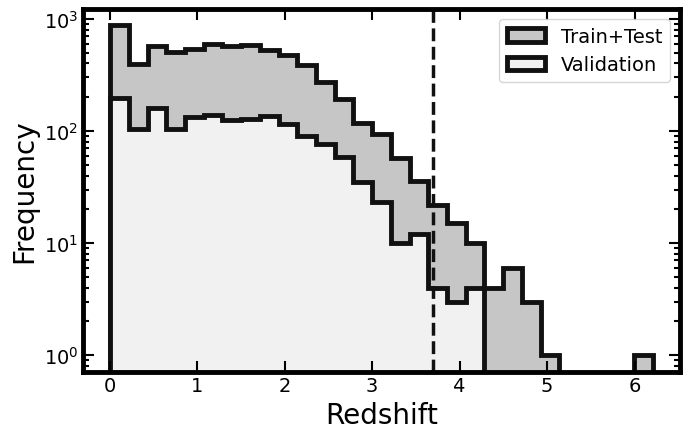

In [36]:
fig             = plt.figure(figsize=(7,4.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[:, 'Z'])
max_score  = np.nanmax(full_catalog_df.loc[:, 'Z'])
score_bins = np.linspace(min_score, max_score, 30)

ax1.hist(train_test_df.loc[:, 'Z'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label='Train+Test')
ax1.hist(validation_df.loc[:, 'Z'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.95), alpha=1.0, label='Validation')

ax1.axvline(x=3.7, ls='--', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
# ax1.set_xlim(left=min_score - 1e-2, right=max_score + 1e-2)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

Save indices of sources in validation sub-set for future steps.

In [37]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_radio_01.txt', X=val_idx, header='Indices from first radio detection training.', fmt='%i')

---

## Use Correlation matrix to discard some features

In [38]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [39]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [40]:
rsd_vals

z_y         310.966140
i_z         253.244252
K_W3        212.477336
i_y         167.196896
r_i         139.584595
W1_W2       134.155901
g_r         118.173271
r_z         113.408866
r_y         109.079886
g_i          98.627995
g_z          89.530402
g_y          88.621066
H_W3         70.152723
Z            66.280465
y_W1         64.840897
z_W1         58.296775
J_W3         56.616933
y_W2         55.159213
i_W1         54.876160
r_W1         54.297274
g_W1         54.260731
y_J          52.239443
z_W2         48.834010
z_J          47.685864
y_H          46.984967
i_J          45.806295
i_W2         45.715297
r_W2         43.884964
g_W2         43.321863
z_H          43.187078
r_J          43.059930
i_H          41.789020
W1_W3        40.751065
g_J          40.708291
W2_W3        40.594992
y_K          40.343280
r_H          39.687561
g_H          38.010230
z_K          37.533209
i_K          36.614656
H_K          35.198398
r_K          34.842270
J_H          34.207025
g_K        

In [41]:
correlation = norm_train_test_df.corr()

In [42]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [43]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [44]:
target_feat = 'Z'

In [45]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [46]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [47]:
list_drop_corr

['g_H',
 'r_H',
 'y_H',
 'i_H',
 'J_W1',
 'z_H',
 'J_W2',
 'J_W3',
 'Jmag',
 'J_W4',
 'g_K',
 'y_K',
 'r_K',
 'i_K',
 'H_W1',
 'z_K',
 'H_W2',
 'Kmag',
 'rmag',
 'zmag',
 'W2mproPM',
 'K_W1',
 'r_W4',
 'i_W4',
 'W2_W4',
 'H_W3',
 'r_J',
 'W1mproPM',
 'gmag',
 'i_J',
 'g_W2',
 'imag',
 'ymag',
 'r_W3',
 'z_W4',
 'J_K',
 'g_W4',
 'i_W3',
 'W1_W4',
 'y_W4',
 'z_J',
 'r_W1',
 'H_W4',
 'W2_W3',
 'r_W2',
 'z_W3',
 'i_W2',
 'i_W1',
 'y_W2',
 'z_W2',
 'Hmag',
 'W3mag',
 'g_z',
 'g_W3',
 'g_y',
 'g_i',
 'z_W1',
 'y_W3',
 'r_y',
 'K_W2',
 'W3_W4']

In [48]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [49]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [50]:
corr_discard = norm_train_test_discard.corr()

In [51]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

Z         Z           1.000000
y_J       g_J         0.747526
          band_num    0.722021
W4mag     K_W3        0.699869
z_y       i_y         0.686586
K_W4      K_W3        0.685105
y_W1      g_W1        0.656637
W1_W3     Z           0.652195
band_num  H_K         0.636162
r_i       r_z         0.635700
r_z       i_z         0.626342
g_r       g_W1        0.624409
W1_W3     y_J         0.619692
          band_num    0.598810
g_J       g_W1        0.585116
dtype: float64

Text(1049.9166666666667, 0.5, 'feature')

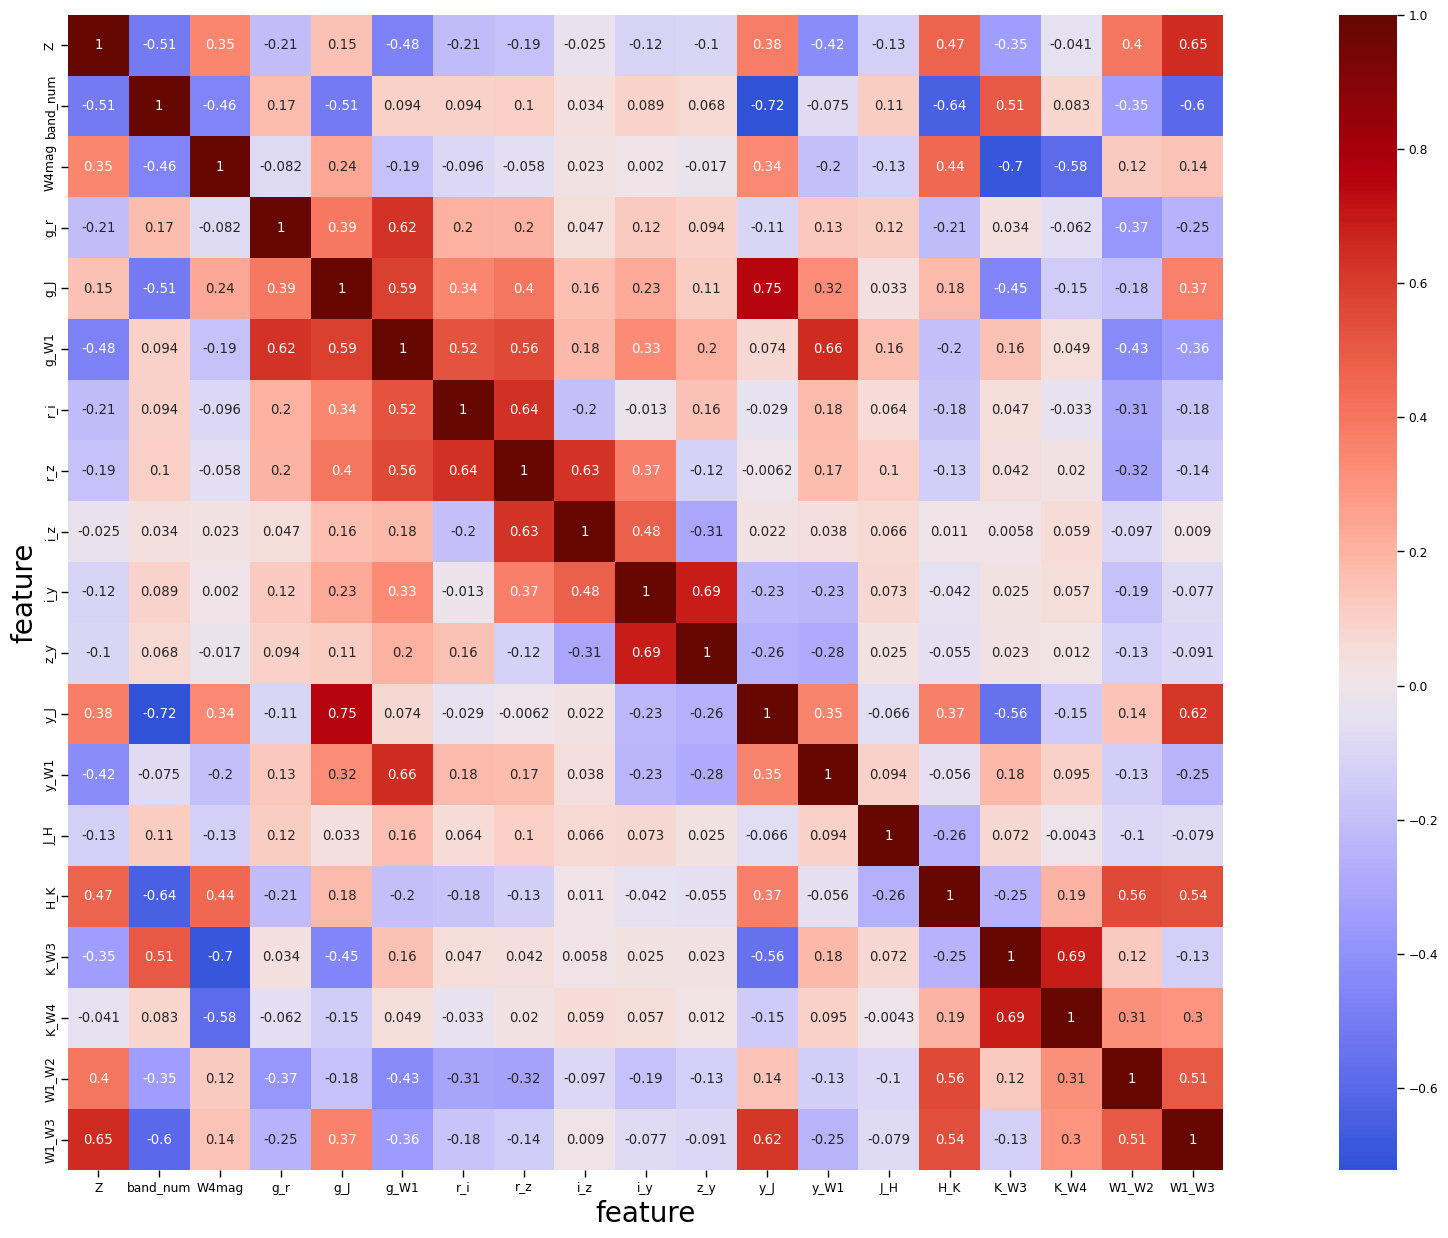

In [52]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [53]:
# norm_train_test_discard.loc[:, 'Z'] = norm_train_test_discard.loc[:, 'Z'].astype(bool)

In [54]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [55]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y       
H_K       H_K         1.000000
J_H       band_num    0.453098
Z         H_K         0.448211
H_K       band_num    0.443836
band_num  y_J         0.438583
K_W4      W4mag       0.431603
J_H       H_K         0.401951
K_W4      K_W3        0.356431
W4mag     K_W3        0.300987
K_W3      K_W4        0.259966
y_J       band_num    0.252157
band_num  H_K         0.237824
K_W4      band_num    0.230529
K_W3      y_J         0.208297
          W4mag       0.202340
y_J       g_J         0.201436
K_W4      H_K         0.194128
band_num  W1_W3       0.187193
          Z           0.182397
W4mag     band_num    0.181676
dtype: float64

In [56]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [57]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [58]:
target_feat = 'Z'

In [59]:
list_drop_pps = []

In [60]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [61]:
list_drop_pps

[]

In [62]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [63]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'Z', random_seed=seed)

In [64]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,band_num,Z,0.182397,regression,True,mean absolute error,0.114438,0.093565,DecisionTreeRegressor()
1,H_K,Z,0.176864,regression,True,mean absolute error,0.114438,0.094198,DecisionTreeRegressor()
2,J_H,Z,0.174250,regression,True,mean absolute error,0.114438,0.094497,DecisionTreeRegressor()
3,K_W4,Z,0.146129,regression,True,mean absolute error,0.114438,0.097715,DecisionTreeRegressor()
4,W1_W3,Z,0.142263,regression,True,mean absolute error,0.114438,0.098158,DecisionTreeRegressor()
5,W4mag,Z,0.086693,regression,True,mean absolute error,0.114438,0.104517,DecisionTreeRegressor()
6,W1_W2,Z,0.046240,regression,True,mean absolute error,0.114438,0.109147,DecisionTreeRegressor()
7,K_W3,Z,0.031263,regression,True,mean absolute error,0.114438,0.110861,DecisionTreeRegressor()
8,g_r,Z,0.000000,regression,True,mean absolute error,0.114438,0.135189,DecisionTreeRegressor()
9,g_J,Z,0.000000,regression,True,mean absolute error,0.114438,0.150875,DecisionTreeRegressor()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [65]:
final_feats = pps_pred_target.x.to_list()  # Before Boruta


In [66]:
feats_2_discard = list_drop_corr + list_drop_pps

Boruta discards one feature.

In [67]:
exp_radio = pyr.setup(data=train_df, test_data=test_df, target='Z', session_id=seed, silent=True,\
                      feature_selection=False, feature_selection_method='boruta',\
                      numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                      transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                      normalize_method='zscore', use_gpu=False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,Z
2,Original Data,"(4814, 80)"
3,Missing Values,False
4,Numeric Features,18
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(4814, 18)"


In [68]:
pyr.get_config('X').columns

Index(['band_num', 'W4mag', 'g_r', 'g_J', 'g_W1', 'r_i', 'r_z', 'i_z', 'i_y',
       'z_y', 'y_J', 'y_W1', 'J_H', 'H_K', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3'],
      dtype='object')

In [69]:
pyr.models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


Add custom metrics

In [70]:
pyr.add_metric('s_mad',  'sigma_mad',    sigma_mad,    greater_is_better=False)
pyr.add_metric('s_nmad', 'sigma_nmad',   sigma_nmad,   greater_is_better=False)
pyr.add_metric('s_z',    'sigma_z',      sigma_z,      greater_is_better=False)
pyr.add_metric('s_z_n',  'sigma_z_norm', sigma_z_norm, greater_is_better=False)
pyr.add_metric('out_f',  'outlier_fr',   outlier_frac, greater_is_better=False)

Name                                                        outlier_fr
Display Name                                                outlier_fr
Score Function               <function outlier_frac at 0x7fd1e56d6160>
Scorer               make_scorer(outlier_frac, greater_is_better=Fa...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Custom                                                            True
Name: out_f, dtype: object

In [71]:
metric_2_opt          = 's_mad'
final_selection_reg   = ['rf', 'et', 'catboost', 'dt', 'xgboost', 'dummy']  # knn discarded: no feature importances
initial_selection_reg = ['dt', 'rf', 'et', 'gbr', 'xgboost', 'catboost', 'dummy']  # Only tree-based models (except lightgbm, small sample => too slow)
n_models              = 5
top_model_z           = pyr.compare_models(n_select=n_models, include=final_selection_reg, sort=metric_2_opt)  # 1:15 hour for used_models_clf
# top_model_z           = pyr.compare_models(n_select=n_models, include=initial_selection_reg, sort=metric_2_opt)  # 5 minutes, using all models.

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr,TT (Sec)
rf,Random Forest Regressor,0.2543,0.1974,0.4437,0.7424,0.1767,0.4006,0.1828,0.0822,0.4437,0.2099,0.2077,0.3630
et,Extra Trees Regressor,0.2537,0.1907,0.4361,0.7512,0.1707,0.3962,0.1944,0.0888,0.4361,0.1920,0.2121,0.1090
catboost,CatBoost Regressor,0.2606,0.1792,0.4227,0.7662,0.1689,0.4850,0.2197,0.1033,0.4227,0.1914,0.2341,0.5810
dt,Decision Tree Regressor,0.3524,0.4158,0.6433,0.4551,0.2502,0.4804,0.2215,0.0998,0.6433,0.3119,0.2734,0.2260
xgboost,Extreme Gradient Boosting,0.2832,0.2093,0.4570,0.7269,0.1825,0.5073,0.2450,0.1158,0.4570,0.2122,0.2545,9.3230
gbr,Gradient Boosting Regressor,0.3144,0.2315,0.4805,0.6979,0.1923,0.5873,0.2966,0.1382,0.4805,0.2157,0.3110,0.1930
dummy,Dummy Regressor,0.7159,0.7671,0.8756,-0.0016,0.3990,3.0250,0.9844,0.3938,0.8756,0.5017,0.7142,0.0100


Thus, we select `rf` as meta learner. It has the best scores in sigma_mad, sigma_nmad and outlier fraction.  
These are the values we care the most about.

Thus, we stack the models.

In [72]:
stacked_model_z = pyr.stack_models(estimator_list=top_model_z[1:], meta_model=top_model_z[0], optimize=metric_2_opt)

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.2286,0.1544,0.3929,0.8036,0.1509,0.2899,0.1685,0.0704,0.3929,0.1605,0.1846
1,0.2329,0.1858,0.4311,0.7705,0.1593,0.2898,0.1672,0.0744,0.4311,0.1879,0.1950
2,0.2152,0.1564,0.3955,0.7765,0.1614,0.3682,0.1450,0.0637,0.3955,0.2023,0.1680
3,0.2270,0.1709,0.4134,0.7715,0.1649,0.3050,0.1555,0.0695,0.4134,0.1965,0.1701
4,0.2451,0.2042,0.4518,0.7246,0.1818,0.3580,0.1792,0.0787,0.4518,0.2049,0.1871
5,0.2359,0.2009,0.4483,0.7519,0.1753,0.2888,0.1444,0.0654,0.4483,0.1937,0.1663
6,0.2189,0.1319,0.3631,0.8156,0.1452,0.2845,0.1654,0.0720,0.3631,0.1668,0.1809
7,0.2391,0.1827,0.4274,0.7645,0.1780,0.3573,0.1640,0.0731,0.4274,0.1953,0.2017
8,0.2319,0.1810,0.4255,0.7729,0.1657,0.3539,0.1620,0.0706,0.4255,0.2187,0.1933


In [73]:
tuned_z_reg = pyr.tune_model(stacked_model_z, early_stopping='asha', optimize=metric_2_opt,\
                             search_library='tune-sklearn', search_algorithm='bayesian')  # 1h30 'scikit-optimize', 'tune-sklearn',, 'bayesian', 'random'

(_Trainable pid=13539) 
(_Trainable pid=13539) libgomp: Thread creation failed: Resource temporarily unavailable
(_Trainable pid=13539) 
(_Trainable pid=13539) libgomp: Thread creation failed: Resource temporarily unavailable
Trial _Trainable_91f46714: Error processing event.


RayTaskError(TerminatedWorkerError): [36mray::_Trainable.train()[39m (pid=13539, ip=194.117.9.85, repr=<tune_sklearn._trainable._Trainable object at 0x7f781b841e20>)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/ray/tune/trainable.py", line 315, in train
    result = self.step()
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/tune_sklearn/_trainable.py", line 106, in step
    return self._train()
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/tune_sklearn/_trainable.py", line 237, in _train
    scores = cross_validate(
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 242, in cross_validate
    scores = parallel(
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/parallel.py", line 1046, in __call__
    while self.dispatch_one_batch(iterator):
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/pycaret/internal/pipeline.py", line 118, in fit
    result = super().fit(X, y=y, **fit_kwargs)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/ensemble/_stacking.py", line 680, in fit
    return super().fit(X, y, sample_weight)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/ensemble/_stacking.py", line 178, in fit
    predictions = Parallel(n_jobs=self.n_jobs)(
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 542, in wrap_future_result
    return future.result(timeout=timeout)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/concurrent/futures/_base.py", line 444, in result
    return self.__get_result()
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/concurrent/futures/_base.py", line 389, in __get_result
    raise self._exception
joblib.externals.loky.process_executor.TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {EXIT(1)}

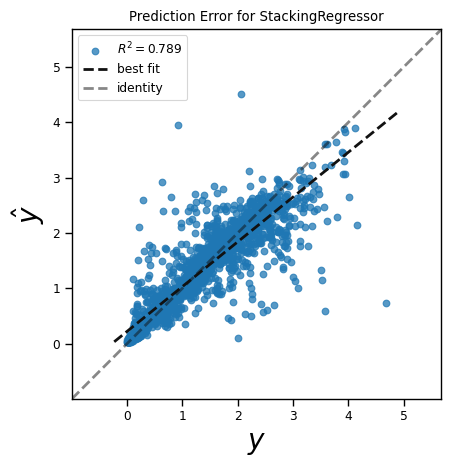

In [74]:
pyr.plot_model(tuned_z_reg, plot='error')

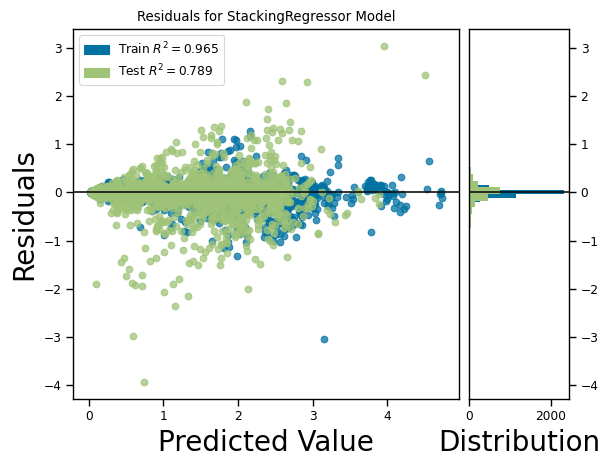

In [75]:
pyr.plot_model(tuned_z_reg, plot='residuals')

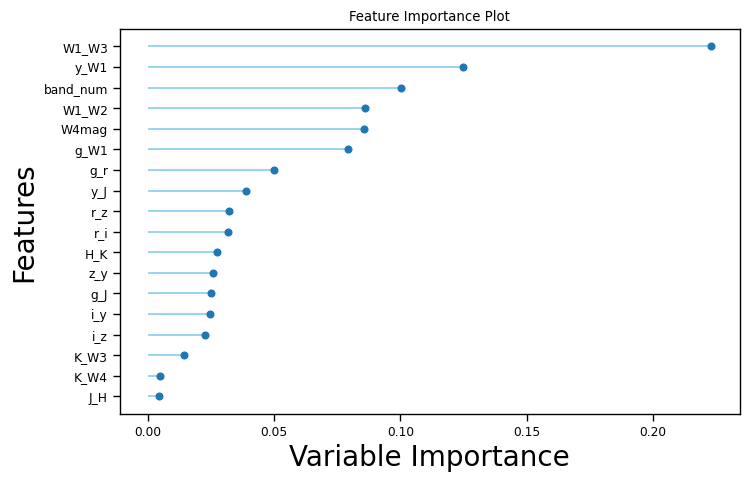

In [76]:
pyr.plot_model(tuned_z_reg.estimators_[0], plot='feature_all')

In [77]:
pyr.plot_model(tuned_z_reg.final_estimator, plot='parameter')

,Parameters
bootstrap,False
ccp_alpha,0.0
criterion,mae
max_depth,9
max_features,0.6346363645439446
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,3.221765456072098e-08
min_impurity_split,None
min_samples_leaf,5


In [78]:
plt.rcParams.update(plt.rcParamsDefault)

In [79]:
pyr.predict_model(tuned_z_reg)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2154,0.1598,0.3998,0.7891,0.1543,0.2558,0.1376,0.0632,0.3998,0.1676,0.1650


,band_num,W4mag,g_r,g_J,g_W1,r_i,r_z,i_z,i_y,z_y,y_J,y_W1,J_H,H_K,K_W3,K_W4,W1_W2,W1_W3,Z,Label
0,-0.149167,0.453514,-0.478535,-0.103420,-1.595909,-0.740850,-0.600954,-0.084618,0.179310,0.232765,0.336084,-1.669784,-0.060446,0.332074,-0.567041,-0.118167,-0.165340,1.274272,3.050,2.582941
1,-0.149167,0.453514,0.816510,1.457169,1.154584,1.215041,1.129652,0.234532,0.925548,0.823078,0.597289,0.098378,-0.060446,0.332074,-0.567041,-0.118167,-1.573200,0.177796,0.565,0.562610
2,-0.149167,0.453514,-0.939821,-1.051940,-1.031812,0.057363,-0.282042,-0.400949,-0.625795,-0.396261,-0.443228,-0.410473,-0.060446,0.332074,0.905410,-0.118167,2.184015,0.336261,1.731,1.646353
3,-0.149167,0.453514,0.395828,0.716834,1.223561,-1.163777,-0.295050,0.665636,0.576076,0.075849,0.799159,1.716808,-0.060446,0.332074,-0.567041,-0.118167,-0.619997,-0.985143,0.998,0.999909
4,-0.149167,0.453514,0.031741,-0.861836,-0.381515,0.435871,-0.377620,-0.883094,-0.698926,-0.072960,-0.773574,-0.359038,-0.060446,0.332074,-0.567041,-0.118167,0.796954,-1.026211,1.200,1.478286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,-0.149167,0.453514,0.079712,0.543744,0.527834,0.770443,0.140754,-0.588535,0.939810,1.541981,0.027250,-0.336647,-0.060446,0.332074,-0.567041,-0.118167,-1.076535,-0.227778,0.464,0.532746
2038,-0.149167,0.453514,-0.226487,0.452210,0.338821,1.045505,0.045380,-1.000922,-0.033576,0.775262,0.385293,0.077109,-0.060446,0.332074,-0.567041,-0.118167,-0.869795,-0.103208,0.581,0.823757
2039,1.641389,0.453514,0.431799,-0.781405,0.083119,0.609123,0.113709,-0.453695,-0.406992,-0.113698,-1.116460,-0.274319,1.804100,-2.248907,0.821294,-0.118167,-1.277776,-1.024109,0.168,0.123735
2040,-0.149167,0.453514,-0.878987,-0.986582,-1.086981,-0.173081,-0.406185,-0.341318,-0.891875,-0.731556,-0.179733,-0.209725,-0.060446,0.332074,0.816153,-0.118167,1.748466,0.395899,1.567,1.638714


In [80]:
test_prediction_reg = pyr.predict_model(tuned_z_reg)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2154,0.1598,0.3998,0.7891,0.1543,0.2558,0.1376,0.0632,0.3998,0.1676,0.1650


In [81]:
final_z_reg = pyr.finalize_model(tuned_z_reg)

/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe./home/rcarvajal/.miniforge

In [82]:
if save_model_flag:
    pyr.save_model(final_z_reg, 'models/regression_z_ago_04_2022')  # Model (it will be saved with .pkl extension) regression_z_may_17_2022
    # pyr.save_config('models/config_regression_z_ago_04_2022')  # Configuration file config_regression_z_may_17_2022

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [66]:
if load_model_flag:
    final_z_reg = pyr.load_model('models/regression_z_ago_04_2022')

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [84]:
estimators_list = get_base_estimators_names(final_z_reg)

In [85]:
extended_data_z = validation_df.loc[:, get_final_column_names(final_z_reg, validation_df)].copy()
extended_idx_z  = extended_data_z.index
initial_cols_z  = extended_data_z.columns
extended_cols_z = extended_data_z.columns.insert(0, estimators_list[0])
if len(estimators_list) > 1:
    for est_name in estimators_list[1::]:
        extended_cols_z = extended_cols_z.insert(0, est_name)

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [86]:
print('Running data pre-processing:\n')
if isinstance(final_z_reg, sklearn.pipeline.Pipeline):
    prep_steps = final_z_reg.named_steps.items()
else:
    prep_steps = pyr.get_config('prep_pipe').named_steps.items()

for (name, method) in prep_steps:
    if method != 'passthrough':  # and name != 'trained_model':
        print(f'Running {name}')
        extended_data_z = method.transform(extended_data_z)
extended_data_z_df = pd.DataFrame(extended_data_z, columns=extended_cols_z, index=extended_idx_z)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [87]:
if isinstance(final_z_reg, sklearn.pipeline.Pipeline):
    if hasattr(final_z_reg.named_steps['trained_model'].final_estimator_, 'feature_importances_'):
        importances_coef = final_z_reg.named_steps['trained_model'].final_estimator_.feature_importances_
    elif hasattr(final_z_reg.named_steps['trained_model'].final_estimator_, 'coef_'):
        importances_coef = np.abs(np.ravel(final_z_reg.named_steps['trained_model'].final_estimator_.coef_)) *\
                                     extended_data_z_df.loc[:, extended_cols_z].std(axis=0)
else:
    if hasattr(final_z_reg.final_estimator_, 'feature_importances_'):
        importances_coef = final_z_reg.final_estimator_.feature_importances_
    elif hasattr(final_z_reg.final_estimator_, 'coef_'):
        importances_coef = np.abs(np.ravel(final_z_reg.final_estimator_.coef_)) *\
                                     extended_data_z_df.loc[:, extended_cols_z].std(axis=0)

coef_meta_df = pd.DataFrame({'Feature': extended_cols_z, 'Importance': importances_coef})
coef_sorted_meta_df = (
    coef_meta_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_z))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [88]:
if isinstance(final_z_reg, sklearn.pipeline.Pipeline):
    estimators_list  = final_z_reg.named_steps['trained_model'].estimators
    estimators_list_ = final_z_reg.named_steps['trained_model'].estimators_
else:
    estimators_list  = final_z_reg.estimators
    estimators_list_ = final_z_reg.estimators_

In [89]:
base_models_names = [model[0] for model in estimators_list]

In [90]:
coef_sorted_base_df = {}

In [91]:
for model, model_fit in zip(base_models_names, estimators_list_):
    if hasattr(model_fit, 'feature_importances_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_z.drop(base_models_names),
                                     'Importance': model_fit.feature_importances_})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_z.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
    )
    elif hasattr(model_fit, 'coef_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_z.drop(base_models_names),
                                     'Importance': np.abs(np.ravel(model_fit.coef_)) *\
                                     extended_data_z_df.loc[:, extended_cols_z.drop(base_models_names)].std(axis=0)})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_radio.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [92]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [93]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for et...
Calculating for catboost...
Calculating for dt...
Calculating for lightgbm...


et             catboost                   dt             lightgbm  \
     Feature Importance   Feature Importance   Feature Importance   Feature   
0      W1_W3  22.303698     W1_W3  19.136310     W1_W3  39.030093     W1_W2   
1       y_W1  12.476552      y_W1  17.735864      y_W1  14.065893       g_r   
2   band_num  10.028290     W1_W2  11.744571     W1_W2   9.485778      y_W1   
3      W1_W2   8.599263       g_r   8.559807       g_r   6.821594     W1_W3   
4      W4mag   8.538054      g_W1   5.129710       H_K   6.190394       r_z   
5       g_W1   7.923012       r_z   5.003452     W4mag   3.984103       r_i   
6        g_r   4.975470       z_y   4.873083       y_J   3.298493       z_y   
7        y_J   3.868342  band_num   3.907069       r_z   3.094303       i_z   
8        r_z   3.221998       r_i   3.861618       r_i   2.900145      g_W1   
9        r_i   3.160457       H_K   3.820665       z_y   2.293482       i_y   
10       H_K   2.722228       y_J   3.410508       i_z   2.152783       y_J   
11       z_y   2.581457       i_z   3.030548       i_y   1.971220       g_J   
12       g_J   2.509548       i_y   3.015158      g_W1   1.838376      K_W3   
13       i_y   2.458772     W4mag   2.669061      K_W3   1.038133     W4mag   
14       i_z   2.247655      K_W3   1.606758      K_W4   0.792961       H_K   
15      K_W3   1.444526       g_J   1.538084       g_J   0.678294       J_H   
16      K_W4   0.490190       J_H   0.537699  band_num   0.198737  band_num   
17       J_H   0.450488      K_W4   0.420035       J_H   0.165219      K_W4   

               
   Importance  
0   13.566667  
1   12.766667  
2   10.800000  
3    7.800000  
4    7.266667  
5    6.800000  
6    6.533333  
7    6.333333  
8    6.000000  
9    5.033333  
10   4.500000  
11   4.166667  
12   2.066667  
13   1.933333  
14   1.533333  
15   1.266667  
16   1.033333  
17   0.600000

In [94]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,lightgbm,47.913258
1,dt,23.968604
2,et,10.067198
3,catboost,5.293681
4,g_r,1.874176
5,r_i,1.597779
6,H_K,1.566433
7,W1_W2,1.351090
8,i_z,1.290334
9,z_y,0.940039


Feature importances scaled to sum 100
Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
--------------------
top features:
Feature	Importance
W1_W2	13.505
g_r	12.627
y_W1	11.025
W1_W3	8.180
r_z	7.191
r_i	6.703
z_y	6.477
i_z	6.224
g_W1	5.971
i_y	4.966
y_J	4.464
g_J	4.080
K_W3	2.051
W4mag	1.960
H_K	1.609
J_H	1.243
band_num	1.129
K_W4	0.594


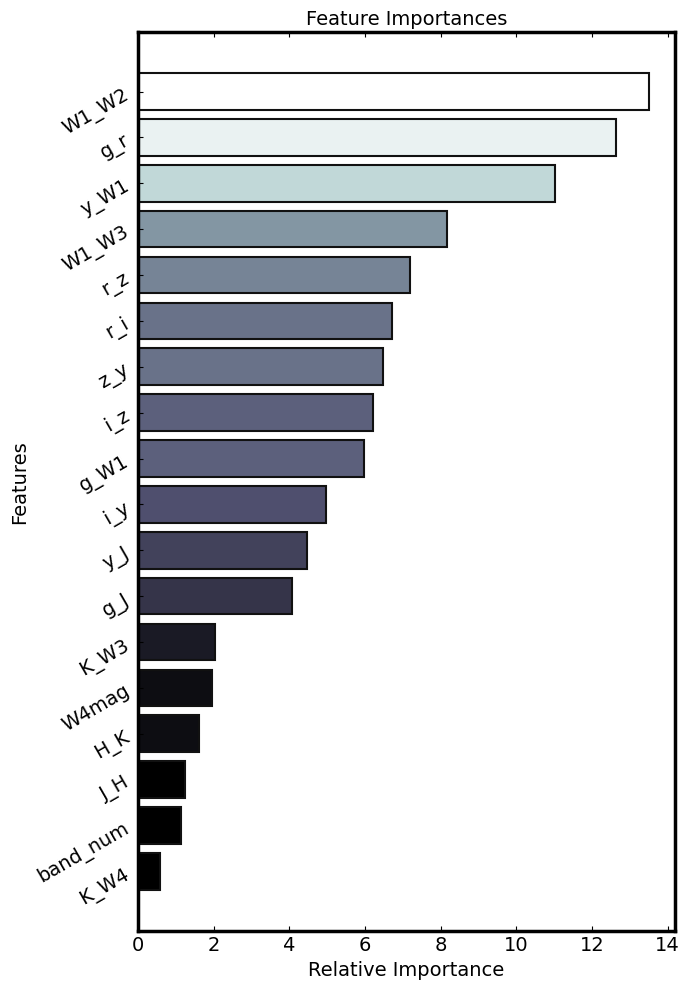

In [95]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = get_feature_importances_df(final_z_reg, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig('plots/feat_imp_regression_z_04.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

In [96]:
validation_prediction_reg = pyr.predict_model(final_z_reg, data=validation_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2371,0.1727,0.4155,0.7738,0.1670,0.3163,0.1666,0.0753,0.4155,0.2031,0.1835


In [97]:
validation_prediction_reg.loc[:, ['Z', 'Label']].describe()

,Z,Label
count,1662.000000,1662.000000
mean,1.335170,1.332364
std,0.873968,0.795901
min,0.003000,0.025668
25%,0.557500,0.689154
50%,1.279000,1.333325
75%,1.944750,1.944266
max,4.247000,4.135893


In [98]:
# clb.vmax

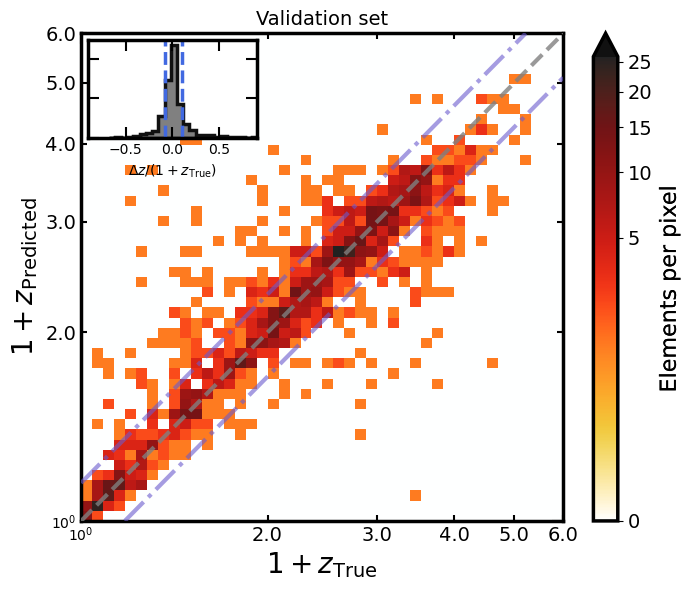

In [99]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')

# norm = ImageNormalize(vmin=0., vmax=5, stretch=LogStretch())
# norm = ImageNormalize(vmin=0., vmax=4)
vmax_dens = 331
# norm = ImageNormalize(vmin=0., stretch=LogStretch())
norm = ImageNormalize(vmin=0., stretch=PowerStretch(0.3))

filt_pair_z   = np.isfinite(validation_prediction_reg.loc[:, 'Z']) & np.isfinite(validation_prediction_reg.loc[:, 'Label'])
max_for_range = np.nanmax([np.nanmax(1 + validation_prediction_reg.loc[filt_pair_z, 'Z']),\
                           np.nanmax(1 + validation_prediction_reg.loc[filt_pair_z, 'Label'])])

dens_1 = ax1.scatter_density((1 + validation_prediction_reg.loc[:, 'Z'].sample(frac=1, random_state=seed)),\
            (1 + validation_prediction_reg.loc[:, 'Label'].sample(frac=1, random_state=seed)),\
            cmap=plt.get_cmap('cet_linear_kryw_5_100_c64_r', vmax_dens), zorder=0, dpi=10, norm=norm, alpha=0.93)
ax1.axline((2., 2.), (3., 3.), ls='--', marker=None, c='Gray', alpha=0.8, lw=3.0, zorder=20)
ax1.axline(xy1=(1., 1.15), xy2=(2., 2.3), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)
ax1.axline(xy1=(1., 0.85), xy2=(2., 1.7), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)


clb = plt.colorbar(dens_1, extend='max', norm=norm)
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2)

######
axins = inset_axes(ax1, width='35%', height='20%', loc=2)
res_z_z = (validation_prediction_reg.loc[:, 'Label'] - validation_prediction_reg.loc[:, 'Z']) / (1 + validation_prediction_reg.loc[:, 'Z'])
axins.hist(res_z_z, histtype='stepfilled', fc='grey', ec='k', bins=50, lw=2.5)

axins.axvline(x=np.nanpercentile(res_z_z, [15.9]), ls='--', lw=2.5, c='royalblue')
axins.axvline(x=np.nanpercentile(res_z_z, [84.1]), ls='--', lw=2.5, c='royalblue')

axins.set_xlabel('$\Delta z / (1 + z_{\mathrm{True}})$', fontsize=10)
# axins.set_ylabel('Frequency', fontsize=20)
axins.tick_params(labelleft=False, labelbottom=True)
axins.tick_params(which='both', top=True, right=True, direction='in')
axins.tick_params(axis='both', which='major', labelsize=10)
axins.tick_params(which='major', length=8, width=1.5)
axins.tick_params(which='minor', length=4, width=1.5)
plt.setp(axins.spines.values(), linewidth=2.5)
plt.setp(axins.spines.values(), linewidth=2.5)
# ax1.grid(zorder=-10)
axins.set_xlim(left=-0.9, right=0.9)
# axins.figure.set_facecolor('b')
######


ax1.set_xlabel('$1 + z_{\mathrm{True}}$', fontsize=20)
ax1.set_ylabel('$1 + z_{\mathrm{Predicted}}$', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.xaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
ax1.yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
ax1.set_xlim(left=1., right=np.ceil(max_for_range))
ax1.set_ylim(bottom=1., top=np.ceil(max_for_range))
# ax1.grid(zorder=0)
# ax1.set_xlim(left=min_full_eddr, right=max_full_eddr)
# ax1.set_aspect('equal', 'box')
# ax1.set_aspect('auto', 'datalim')
ax1.set_title('Validation set', fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/compare_plot_validation_redshift_04.pdf', bbox_inches='tight')
plt.show()

In [100]:
# train_size         = 0.7
# data_split_shuffle = True
# _stratify_columns  = _get_columns_to_stratify_by(
#             train_test_df.drop(columns=['Z']), train_test_df.loc[:, 'Z'], False, 'Z'
#         )
# 
# X_train, X_test, y_train, y_test = train_test_split(
#                 train_test_df.drop(columns=['Z']),
#                 train_test_df.loc[:, 'Z'],
#                 test_size=1 - train_size,
#                 stratify=_stratify_columns,
#                 random_state=seed,
#                 shuffle=data_split_shuffle,
#             )
# train_df        = pd.concat([X_train, y_train], axis=1)
# test_df         = pd.concat([X_test, y_test], axis=1)

In [101]:
train_prediction_reg      = pyr.predict_model(final_z_reg, data=train_df)
test_prediction_reg       = pyr.predict_model(final_z_reg, data=test_df)
train_test_prediction_reg = pyr.predict_model(final_z_reg, data=train_test_df)
train_test_prediction_reg = pyr.predict_model(final_z_reg, data=train_test_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.0841,0.0265,0.1629,0.9654,0.0562,0.0884,0.0597,0.0277,0.1629,0.0576,0.0280


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2154,0.1598,0.3998,0.7891,0.1543,0.2558,0.1376,0.0632,0.3998,0.1676,0.1650


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.1232,0.0662,0.2574,0.9133,0.0965,0.1383,0.0762,0.0347,0.2574,0.1034,0.0688


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.1232,0.0662,0.2574,0.9133,0.0965,0.1383,0.0762,0.0347,0.2574,0.1034,0.0688


In [102]:
sigma_mad_train         = sigma_mad(train_prediction_reg.loc[:, 'Z'],         train_prediction_reg.loc[:, 'Label'])
sigma_mad_test          = sigma_mad(test_prediction_reg.loc[:, 'Z'],          test_prediction_reg.loc[:, 'Label'])
sigma_mad_train_test    = sigma_mad(train_test_prediction_reg.loc[:, 'Z'],    train_test_prediction_reg.loc[:, 'Label'])
sigma_mad_valid         = sigma_mad(validation_prediction_reg.loc[:, 'Z'],    validation_prediction_reg.loc[:, 'Label'])

In [103]:
sigma_nmad_train        = sigma_nmad(train_prediction_reg.loc[:, 'Z'],        train_prediction_reg.loc[:, 'Label'])
sigma_nmad_test         = sigma_nmad(test_prediction_reg.loc[:, 'Z'],         test_prediction_reg.loc[:, 'Label'])
sigma_nmad_train_test   = sigma_nmad(train_test_prediction_reg.loc[:, 'Z'],         train_test_prediction_reg.loc[:, 'Label'])
sigma_nmad_valid        = sigma_nmad(validation_prediction_reg.loc[:, 'Z'],   validation_prediction_reg.loc[:, 'Label'])

In [104]:
sigma_z_train           = sigma_z(train_prediction_reg.loc[:, 'Z'],           train_prediction_reg.loc[:, 'Label'])
sigma_z_test            = sigma_z(test_prediction_reg.loc[:, 'Z'],            test_prediction_reg.loc[:, 'Label'])
sigma_z_train_test      = sigma_z(train_test_prediction_reg.loc[:, 'Z'],      train_test_prediction_reg.loc[:, 'Label'])
sigma_z_valid           = sigma_z(validation_prediction_reg.loc[:, 'Z'],      validation_prediction_reg.loc[:, 'Label'])

In [105]:
sigma_z_norm_train      = sigma_z_norm(train_prediction_reg.loc[:, 'Z'],      train_prediction_reg.loc[:, 'Label'])
sigma_z_norm_test       = sigma_z_norm(test_prediction_reg.loc[:, 'Z'],       test_prediction_reg.loc[:, 'Label'])
sigma_z_norm_train_test = sigma_z_norm(train_test_prediction_reg.loc[:, 'Z'], train_test_prediction_reg.loc[:, 'Label'])
sigma_z_norm_valid      = sigma_z_norm(validation_prediction_reg.loc[:, 'Z'], validation_prediction_reg.loc[:, 'Label'])

In [106]:
out_frac_train          = outlier_frac(train_prediction_reg.loc[:, 'Z'],      train_prediction_reg.loc[:, 'Label'])
out_frac_test           = outlier_frac(test_prediction_reg.loc[:, 'Z'],       test_prediction_reg.loc[:, 'Label'])
out_frac_train_test     = outlier_frac(train_test_prediction_reg.loc[:, 'Z'], train_test_prediction_reg.loc[:, 'Label'])
out_frac_valid          = outlier_frac(validation_prediction_reg.loc[:, 'Z'], validation_prediction_reg.loc[:, 'Label'])

In [107]:
print('Scores for training set:')
print(f'Sigma MAD:\t\t{sigma_mad_train:.4f}')
print(f'Sigma NMAD:\t\t{sigma_nmad_train:.4f}')
print(f'Sigma z:\t\t{sigma_z_train:.4f}')
print(f'Sigma z norm:\t\t{sigma_z_norm_train:.4f}')
print(f'Out fraction:\t\t{out_frac_train:.4f}')
print('-' * 35)

Scores for training set:
Sigma MAD:		0.0597
Sigma NMAD:		0.0277
Sigma z:		0.1629
Sigma z norm:		0.0576
Out fraction:		0.0280
-----------------------------------


In [108]:
print('Scores for test set:')
print(f'Sigma MAD:\t\t{sigma_mad_test:.4f}')
print(f'Sigma NMAD:\t\t{sigma_nmad_test:.4f}')
print(f'Sigma z:\t\t{sigma_z_test:.4f}')
print(f'Sigma z norm:\t\t{sigma_z_norm_test:.4f}')
print(f'Out fraction:\t\t{out_frac_test:.4f}')
print('-' * 35)

Scores for test set:
Sigma MAD:		0.1376
Sigma NMAD:		0.0632
Sigma z:		0.3998
Sigma z norm:		0.1676
Out fraction:		0.1650
-----------------------------------


In [109]:
print('Scores for validation set:')
print(f'Sigma MAD:\t\t{sigma_mad_valid:.4f}')
print(f'Sigma NMAD:\t\t{sigma_nmad_valid:.4f}')
print(f'Sigma z:\t\t{sigma_z_valid:.4f}')
print(f'Sigma z norm:\t\t{sigma_z_norm_valid:.4f}')
print(f'Out fraction:\t\t{out_frac_valid:.4f}')
print('-' * 35)

Scores for validation set:
Sigma MAD:		0.1666
Sigma NMAD:		0.0753
Sigma z:		0.4155
Sigma z norm:		0.2031
Out fraction:		0.1835
-----------------------------------


Display metrics as DataFrame

In [110]:
metrics_z = np.array([[sigma_mad_train,      sigma_nmad_train,      sigma_z_train,      sigma_z_norm_train,      out_frac_train],\
                      [sigma_mad_test,       sigma_nmad_test,       sigma_z_test,       sigma_z_norm_test,       out_frac_test],\
                      [sigma_mad_train_test, sigma_nmad_train_test, sigma_z_train_test, sigma_z_norm_train_test, out_frac_train_test],\
                      [sigma_mad_valid,      sigma_nmad_valid,      sigma_z_valid,      sigma_z_norm_valid,      out_frac_valid]])

In [111]:
metrics_z_df = pd.DataFrame(data=metrics_z, index=['Train', 'Test', 'Train+Test', 'Validation'],\
                            columns=['\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7'])

In [112]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_z_df)

,σ MAD,σ NMAD,σ z,σ z N,η
Train,0.0597,0.0277,0.1629,0.0576,0.0280
Test,0.1376,0.0632,0.3998,0.1676,0.1650
Train+Test,0.0762,0.0347,0.2574,0.1034,0.0688
Validation,0.1666,0.0753,0.4155,0.2031,0.1835


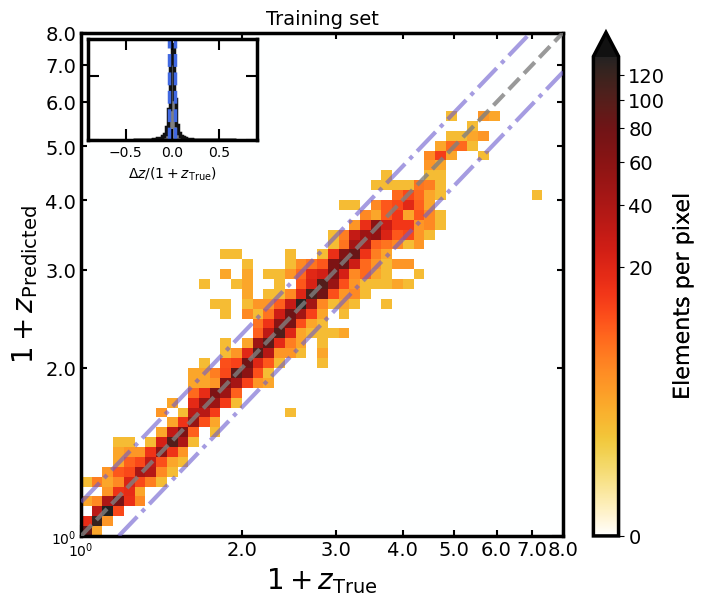

In [113]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')

# norm = ImageNormalize(vmin=0., vmax=5, stretch=LogStretch())
# norm = ImageNormalize(vmin=0., vmax=4)
vmax_dens = 947
# norm = ImageNormalize(vmin=0., stretch=LogStretch())
norm = ImageNormalize(vmin=0., stretch=PowerStretch(0.3))

filt_pair_z = np.isfinite(train_prediction_reg.loc[:, 'Z']) & np.isfinite(train_prediction_reg.loc[:, 'Label'])
max_for_range = np.nanmax([np.nanmax(1 + train_prediction_reg.loc[filt_pair_z, 'Z']),\
                           np.nanmax(1 + train_prediction_reg.loc[filt_pair_z, 'Label'])])

dens_1 = ax1.scatter_density((1 + train_prediction_reg.loc[:, 'Z'].sample(frac=1, random_state=seed)),\
            (1 + train_prediction_reg.loc[:, 'Label'].sample(frac=1, random_state=seed)),\
            cmap=plt.get_cmap('cet_linear_kryw_5_100_c64_r', vmax_dens), zorder=0, dpi=10, norm=norm, alpha=0.93)
ax1.axline((2., 2.), (3., 3.), ls='--', marker=None, c='Gray', alpha=0.8, lw=3.0, zorder=20)
ax1.axline(xy1=(1., 1.15), xy2=(2., 2.3), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)
ax1.axline(xy1=(1., 0.85), xy2=(2., 1.7), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)


clb = plt.colorbar(dens_1, extend='max', norm=norm)
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2)

######
axins = inset_axes(ax1, width='35%', height='20%', loc=2)
res_z_z = (train_prediction_reg.loc[:, 'Label'] - train_prediction_reg.loc[:, 'Z']) / (1 + train_prediction_reg.loc[:, 'Z'])
axins.hist(res_z_z, histtype='stepfilled', fc='grey', ec='k', bins=50, lw=2.5)

axins.axvline(x=np.nanpercentile(res_z_z, [15.9]), ls='--', lw=2.5, c='royalblue')
axins.axvline(x=np.nanpercentile(res_z_z, [84.1]), ls='--', lw=2.5, c='royalblue')

axins.set_xlabel('$\Delta z / (1 + z_{\mathrm{True}})$', fontsize=10)
# axins.set_ylabel('Frequency', fontsize=20)
axins.tick_params(labelleft=False, labelbottom=True)
axins.tick_params(which='both', top=True, right=True, direction='in')
axins.tick_params(axis='both', which='major', labelsize=10)
axins.tick_params(which='major', length=8, width=1.5)
axins.tick_params(which='minor', length=4, width=1.5)
plt.setp(axins.spines.values(), linewidth=2.5)
plt.setp(axins.spines.values(), linewidth=2.5)
# ax1.grid(zorder=-10)
axins.set_xlim(left=-0.9, right=0.9)
# axins.figure.set_facecolor('b')
######


ax1.set_xlabel('$1 + z_{\mathrm{True}}$', fontsize=20)
ax1.set_ylabel('$1 + z_{\mathrm{Predicted}}$', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.xaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
ax1.yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
ax1.set_xlim(left=1., right=np.ceil(max_for_range))
ax1.set_ylim(bottom=1., top=np.ceil(max_for_range))
# ax1.grid(zorder=0)
# ax1.set_xlim(left=min_full_eddr, right=max_full_eddr)
# ax1.set_aspect('equal', 'box')
# ax1.set_aspect('auto', 'datalim')
fig.tight_layout()
ax1.set_title('Training set', fontsize=14)
if save_plot_flag:
    plt.savefig('plots/compare_plot_train_redshift_04.pdf', bbox_inches='tight')
plt.show()

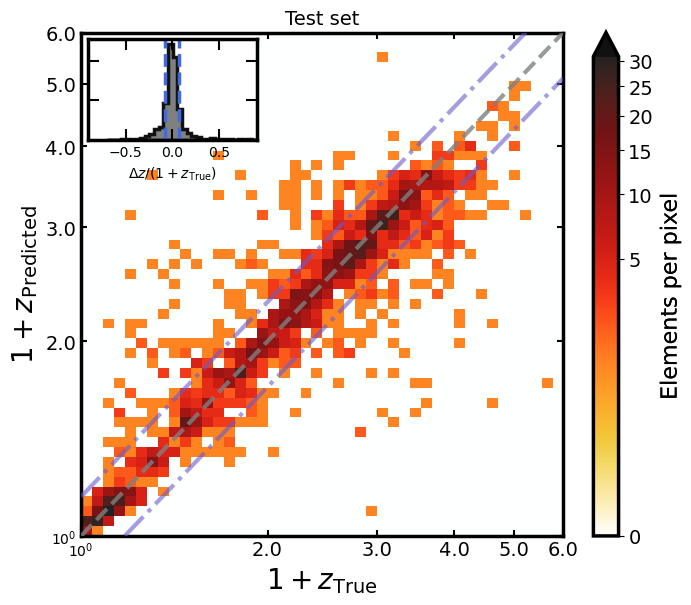

In [114]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')

# norm = ImageNormalize(vmin=0., vmax=5, stretch=LogStretch())
# norm = ImageNormalize(vmin=0., vmax=4)
vmax_dens = 388
# norm = ImageNormalize(vmin=0., stretch=LogStretch())
norm = ImageNormalize(vmin=0., stretch=PowerStretch(0.3))

filt_pair_z = np.isfinite(test_prediction_reg.loc[:, 'Z']) & np.isfinite(test_prediction_reg.loc[:, 'Label'])
max_for_range = np.nanmax([np.nanmax(1 + test_prediction_reg.loc[filt_pair_z, 'Z']),\
                           np.nanmax(1 + test_prediction_reg.loc[filt_pair_z, 'Label'])])

dens_1 = ax1.scatter_density((1 + test_prediction_reg.loc[:, 'Z'].sample(frac=1, random_state=seed)),\
            (1 + test_prediction_reg.loc[:, 'Label'].sample(frac=1, random_state=seed)),\
            cmap=plt.get_cmap('cet_linear_kryw_5_100_c64_r', vmax_dens), zorder=0, dpi=10, norm=norm, alpha=0.93)
ax1.axline((2., 2.), (3., 3.), ls='--', marker=None, c='Gray', alpha=0.8, lw=3.0, zorder=20)
ax1.axline(xy1=(1., 1.15), xy2=(2., 2.3), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)
ax1.axline(xy1=(1., 0.85), xy2=(2., 1.7), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)


clb = plt.colorbar(dens_1, extend='max', norm=norm)
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2)

######
axins = inset_axes(ax1, width='35%', height='20%', loc=2)
res_z_z = (test_prediction_reg.loc[:, 'Label'] - test_prediction_reg.loc[:, 'Z']) / (1 + test_prediction_reg.loc[:, 'Z'])
axins.hist(res_z_z, histtype='stepfilled', fc='grey', ec='k', bins=50, lw=2.5)

axins.axvline(x=np.nanpercentile(res_z_z, [15.9]), ls='--', lw=2.5, c='royalblue')
axins.axvline(x=np.nanpercentile(res_z_z, [84.1]), ls='--', lw=2.5, c='royalblue')

axins.set_xlabel('$\Delta z / (1 + z_{\mathrm{True}})$', fontsize=10)
# axins.set_ylabel('Frequency', fontsize=20)
axins.tick_params(labelleft=False, labelbottom=True)
axins.tick_params(which='both', top=True, right=True, direction='in')
axins.tick_params(axis='both', which='major', labelsize=10)
axins.tick_params(which='major', length=8, width=1.5)
axins.tick_params(which='minor', length=4, width=1.5)
plt.setp(axins.spines.values(), linewidth=2.5)
plt.setp(axins.spines.values(), linewidth=2.5)
# ax1.grid(zorder=-10)
axins.set_xlim(left=-0.9, right=0.9)
# axins.figure.set_facecolor('b')
######


ax1.set_xlabel('$1 + z_{\mathrm{True}}$', fontsize=20)
ax1.set_ylabel('$1 + z_{\mathrm{Predicted}}$', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.xaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
ax1.yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
ax1.set_xlim(left=1., right=np.ceil(max_for_range))
ax1.set_ylim(bottom=1., top=np.ceil(max_for_range))
# ax1.grid(zorder=0)
# ax1.set_xlim(left=min_full_eddr, right=max_full_eddr)
# ax1.set_aspect('equal', 'box')
# ax1.set_aspect('auto', 'datalim')
fig.tight_layout()
ax1.set_title('Test set', fontsize=14)
if save_plot_flag:
    plt.savefig('plots/compare_plot_test_redshift_04.pdf', bbox_inches='tight')
plt.show()

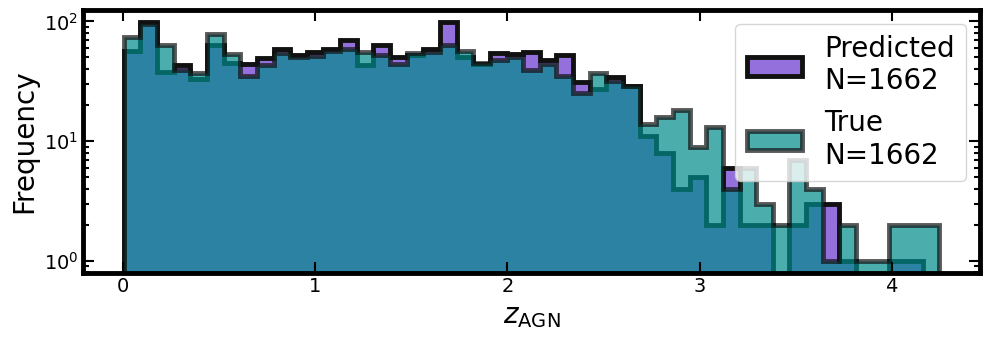

In [115]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin([np.nanmin(validation_prediction_reg.loc[:, 'Z']),\
                           np.nanmin(validation_prediction_reg.loc[:, 'Label'])])
max_for_range = np.nanmax([np.nanmax(validation_prediction_reg.loc[:, 'Z']),\
                           np.nanmax(validation_prediction_reg.loc[:, 'Label'])])
bins_z        = np.linspace(min_for_range, max_for_range, 50)

_, bins, _ = ax1.hist(validation_prediction_reg.loc[:, 'Label'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f"Predicted\nN={np.sum(np.array(validation_prediction_reg.loc[:, 'Label'] > 0))}")
ax1.hist(validation_prediction_reg.loc[:, 'Z'], bins=bins_z, histtype='stepfilled', ec='k', fc='darkcyan',\
         lw=3.5, label=f"True\nN={np.sum(np.array(validation_prediction_reg.loc[:, 'Z'] > 0))}", alpha=0.7)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('$z_{\mathrm{AGN}}$', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=20)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/hist_true_predicted_z_04.pdf')
plt.show()

---

#### Redshift threshold

In order to understand where (in redshift) the predictions are far off from real values, we can use the evolution of the outlier fraction to obtain the point where that happens.

In [116]:
n_elems        = 50
z_range_lin    = np.linspace(0, np.nanmax(train_test_prediction_reg.loc[:, 'Z']), n_elems)
z_range_log    = np.logspace(np.log10(np.abs(np.nanmin(train_test_prediction_reg.loc[:, 'Z']))),\
                          np.log10(np.abs(np.nanmax(train_test_prediction_reg.loc[:, 'Z']))), n_elems)
z_range_lg_inv = np.abs(np.abs(np.nanmax(train_test_prediction_reg.loc[:, 'Z']))) - z_range_log

In [117]:
train_test_prediction_reg = train_test_prediction_reg.rename(columns={'Label': 'pred_Z'})

In [118]:
s_MAD_z_z_lin          = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_lin, sigma_mad,      'Z',            'pred_Z')
s_NMAD_z_z_lin         = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_lin, sigma_nmad,     'Z',            'pred_Z')
sigma_z_z_z_lin        = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_lin, sigma_z,        'Z',            'pred_Z')
sigma_z_N_z_z_lin      = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_lin, sigma_z_norm,   'Z',            'pred_Z')
out_fr_z_z_lin         = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_lin, outlier_frac,   'Z',            'pred_Z')

In [119]:
s_MAD_z_z_log          = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_log, sigma_mad,      'Z',            'pred_Z')
s_NMAD_z_z_log         = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_log, sigma_nmad,     'Z',            'pred_Z')
sigma_z_z_z_log        = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_log, sigma_z,        'Z',            'pred_Z')
sigma_z_N_z_z_log      = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_log, sigma_z_norm,   'Z',            'pred_Z')
out_fr_z_z_log         = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_log, outlier_frac,   'Z',            'pred_Z')

In [120]:
s_MAD_z_z_log_inv      = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_lg_inv, sigma_mad,      'Z',            'pred_Z')
s_NMAD_z_z_log_inv     = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_lg_inv, sigma_nmad,     'Z',            'pred_Z')
sigma_z_z_z_log_inv    = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_lg_inv, sigma_z,        'Z',            'pred_Z')
sigma_z_N_z_z_log_inv  = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_lg_inv, sigma_z_norm,   'Z',            'pred_Z')
out_fr_z_z_log_inv     = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_lg_inv, outlier_frac,   'Z',            'pred_Z')

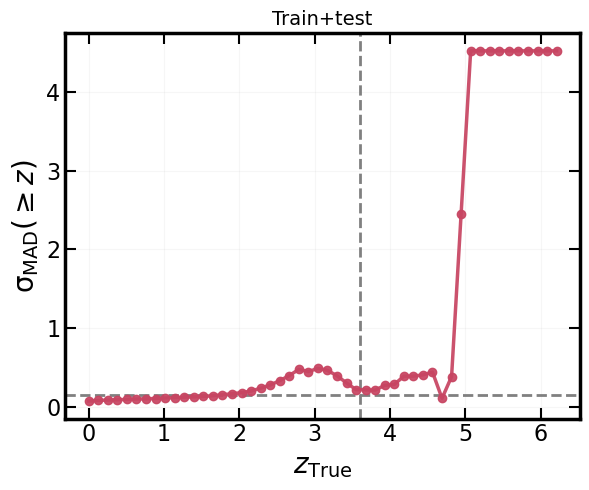

In [126]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, s_MAD_z_z_lin, '\sigma_{MAD}', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/sigma_mad_linear_redshift_train_test.pdf', bbox_inches='tight')
plt.show()

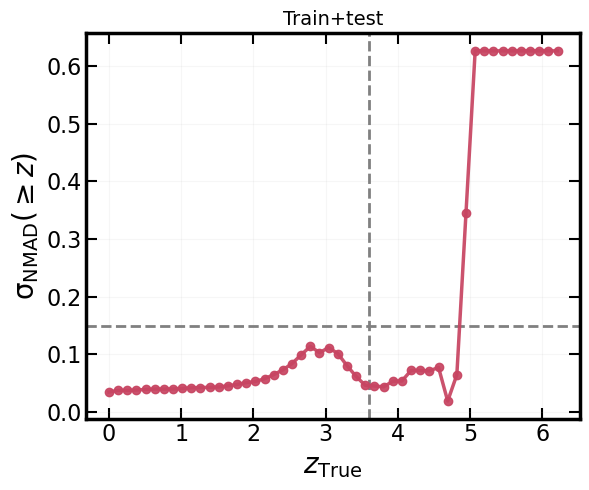

In [127]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, s_NMAD_z_z_lin, '\sigma_{NMAD}', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/sigma_nmad_linear_redshift_train_test.pdf', bbox_inches='tight')
plt.show()

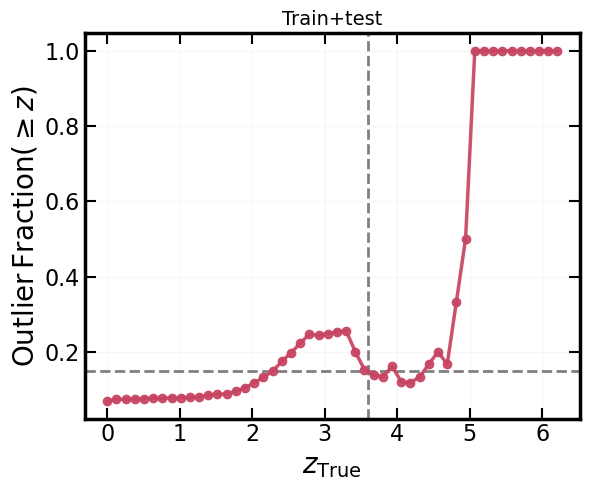

In [122]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, out_fr_z_z_lin, 'Outlier\,Fraction', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/outlier_fraction_linear_redshift_train_test.pdf', bbox_inches='tight')
plt.show()

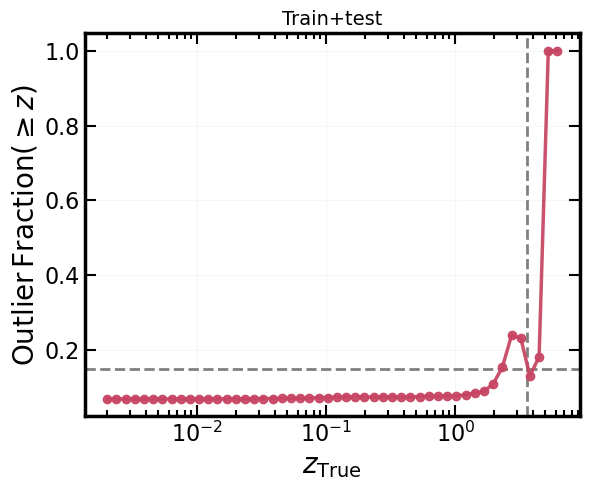

In [123]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='log', yscale='linear')
plot_metric_over_z(z_range_log, out_fr_z_z_log, 'Outlier\,Fraction', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/outlier_fraction_log_redshift_redshift_train_test.pdf', bbox_inches='tight')
plt.show()

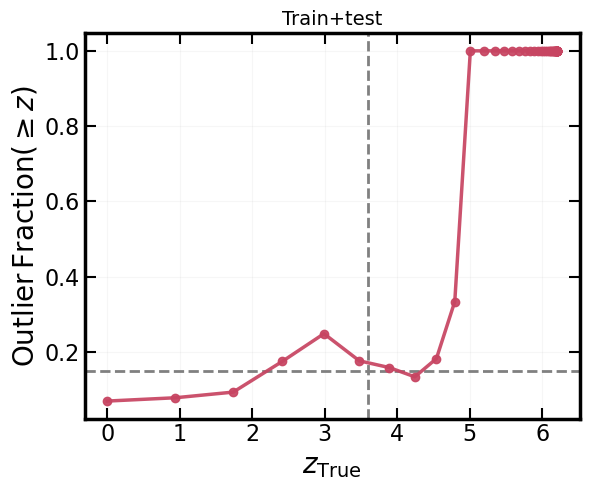

/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int

In [124]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lg_inv, out_fr_z_z_log_inv, 'Outlier\,Fraction', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/outlier_fraction_inv_log_redshift_redshift_train_test.pdf', bbox_inches='tight')
plt.show()